In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
import matplotlib.ticker as tck
import scipy.linalg as LA

import seaborn as sns
import pandas as pd
sns.axes_style("whitegrid")

from tqdm import tqdm

import matplotlib
matplotlib.rcParams['text.usetex'] = True

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

from matplotlib.colors import Normalize

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
L = 5
U = 10.0
lamda = 1.0
delta_stag = 0.0

def rp(txt):
    return (txt.replace('.','p')).replace('-','m')

fname = 'cnf_U'+str(np.round(U,2))+'_l_'+str(np.round(lamda,2))+'_ds_'+str(np.round(delta_stag,2))+'_L'+str(int(L))
mfSoln = np.load(rp(fname)+'.npy')

fig_fname = 'figs/U'+str(np.round(U,2))+'_l_'+str(np.round(lamda,2))+'_ds_'+str(np.round(delta_stag,2))+'_L'+str(int(L))+'.pdf'

In [3]:
Nsites = int(L*L)
Nbands = int(6*Nsites)		# 6 = 3 orbitals x 2 spins

a1 = np.array([1,0])
a2 = np.array([0,1])

pmn = np.zeros([Nsites,2])

for m in range(L):
    for n in range(L):
        p = m + L*n
        pmn[p] = [m,n]

def i_to_rij(i):
    [m1,n1] = pmn[i]
    return np.multiply(a1,m1/float(L)) + np.multiply(a2,n1/float(L))

def XYSar(MFVec):

    XYSarray = np.zeros([3*Nsites, 5]).astype(complex)
    
    ctr = 0
    for i in range(Nsites):
        
        mfsite = MFVec[i,:]
        
        nupA, ndownA, SplusA = mfsite[0:3]
        nupB, ndownB, SplusB = mfsite[3:6]
        nupC, ndownC, SplusC = mfsite[6:]

        uc = i_to_rij(i)
    
        
        sA = np.asarray([np.real(SplusA), np.imag(SplusA), 0.5*(nupA-ndownA)])
        sB = np.asarray([np.real(SplusB), np.imag(SplusB), 0.5*(nupB-ndownB)])
        sC = np.asarray([np.real(SplusC), np.imag(SplusC), 0.5*(nupC-ndownC)])

        # A site
        loc = uc + [0.0,0.5/float(L)]
        XYSarray[ctr,:] = [loc[0], loc[1], sA[0], sA[1], sA[2]]
        # B site
        loc = uc
        XYSarray[ctr+1,:] = [loc[0], loc[1], sB[0], sB[1], sB[2]]
        # A site
        loc = uc + [0.5/float(L),0.0]
        XYSarray[ctr+2,:] = [loc[0], loc[1], sC[0], sC[1], sC[2]]
        
        ctr += 3
        
    return XYSarray

In [4]:
XYspin_loc = XYSar(mfSoln)

In [5]:
spin_ar = XYspin_loc[:,2:]

In [6]:
spin_mod_ar = spin_ar[:,0]*spin_ar[:,0] + spin_ar[:,1]*spin_ar[:,1] + spin_ar[:,2]*spin_ar[:,2]

In [7]:
loc_ar = XYspin_loc[:,0:2]

In [8]:
# create a dot product matrx

dpmat = np.zeros([3*Nsites, 3*Nsites])
rimrjx = np.zeros([3*Nsites, 3*Nsites])
rimrjy = np.zeros([3*Nsites, 3*Nsites])

for ii in range(len(loc_ar)):
    ri = loc_ar[ii]
    si = spin_ar[ii]
    for jj in range(len(loc_ar)):
        rj = loc_ar[jj]
        rij = ri - rj
        sj = spin_ar[jj]
        
        rimrjx[ii,jj] = rij[0]
        rimrjy[ii,jj] = rij[1]
        dpmat[ii,jj] = np.dot(si,sj)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [9]:
def SpinSQ(qx,qy):
    
    sqx = np.sum( np.exp(1j*(qx*loc_ar[:,0] + qy*loc_ar[:,1]))*spin_ar[:,0]   )
    sqy = np.sum( np.exp(1j*(qx*loc_ar[:,0] + qy*loc_ar[:,1]))*spin_ar[:,1]   )
    sqz = np.sum( np.exp(1j*(qx*loc_ar[:,0] + qy*loc_ar[:,1]))*spin_ar[:,2]   )
    
    return np.asarray([sqx, sqy, sqz])

In [10]:
nkpts = 100

Mij = np.zeros([nkpts,nkpts])
Mijx = np.zeros([nkpts,nkpts])
Mijy = np.zeros([nkpts,nkpts])
Mijz = np.zeros([nkpts,nkpts])

shift = np.pi

for i in tqdm(range(nkpts)):
    
    qi = 2.0*np.pi*i/nkpts - shift
    
    for j in range(nkpts):
        
        qj = 2.0*np.pi*j/nkpts - shift
        
        sq = SpinSQ(qi,qj)
        
        Mij[i,j] = LA.norm(sq)**2/Nsites
        Mijx[i,j] = LA.norm(sq[0])**2/Nsites
        Mijy[i,j] = LA.norm(sq[1])**2/Nsites
        Mijz[i,j] = LA.norm(sq[2])**2/Nsites        

100%|██████████| 100/100 [00:01<00:00, 52.38it/s]


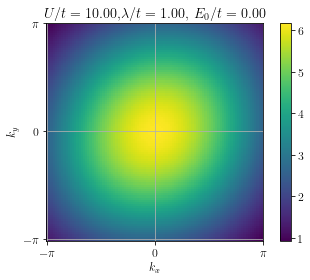

In [11]:
fig,ax = plt.subplots()
cax = ax.imshow(Mij, interpolation='nearest', origin='lower')
fig.colorbar(cax)

xaxis = np.arange(0,nkpts+1,nkpts/2)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)

ax.set_xticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
ax.set_yticklabels([r'$-\pi$',r'$0$',r'$\pi$'])

plt.grid()

plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')

ax.tick_params(axis='both')

title_text = r'$U/t = %3.2f$,$\lambda/t = %3.2f$, $E_0/t = %3.2f$'%(U,lamda,delta_stag)

plt.title(title_text)

plt.show()

#fig.savefig(fig_fname,bbox_inches='tight')

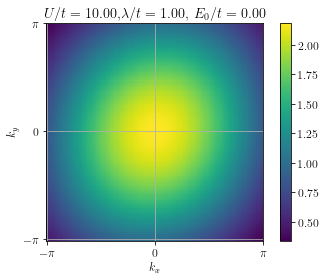

In [20]:
fig,ax = plt.subplots()
cax = ax.imshow(Mijx, interpolation='nearest', origin='lower')
fig.colorbar(cax)

xaxis = np.arange(0,nkpts+1,nkpts/2)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)

ax.set_xticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
ax.set_yticklabels([r'$-\pi$',r'$0$',r'$\pi$'])

plt.grid()

plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')

ax.tick_params(axis='both')

title_text = r'$U/t = %3.2f$,$\lambda/t = %3.2f$, $E_0/t = %3.2f$'%(U,lamda,delta_stag)

plt.title(title_text)

plt.show()

#fig.savefig(fig_fname,bbox_inches='tight')

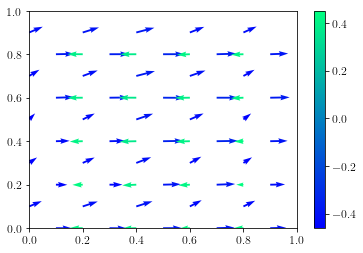

In [13]:
fig,ax = plt.subplots()


colors = np.real(spin_ar[:,2])
norm = Normalize()

#norm.autoscale(colors)
# we need to normalize our colors array to match it colormap domain
# which is [0, 1]



cm = matplotlib.cm.winter

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

plt.quiver(np.real(loc_ar[:,0]),np.real(loc_ar[:,1]),np.real(spin_ar[:,0]),np.real(spin_ar[:,1]),color=cm(norm(colors)))

plt.clim(-1, 1)
plt.colorbar(sm)

plt.xlim([0,1])
plt.ylim([0,1])

plt.show()

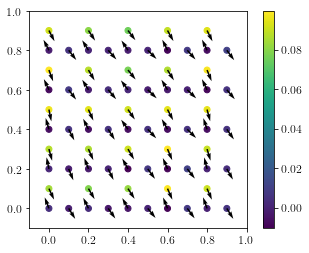

In [17]:
fig,ax = plt.subplots()


colors = np.real(spin_ar[:,2])
norm = Normalize()

norm.autoscale(colors)
# we need to normalize our colors array to match it colormap domain
# which is [0, 1]

cm = matplotlib.cm.copper

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

plt.scatter(np.real(loc_ar[:,0]),np.real(loc_ar[:,1]),c=np.real(spin_ar[:,1]))
plt.colorbar()

plt.quiver(np.real(loc_ar[:,0]),np.real(loc_ar[:,1]),np.real(spin_ar[:,0]),np.real(spin_ar[:,2]))
#plt.colorbar(sm)

plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
ax.set_aspect(1)

plt.show()

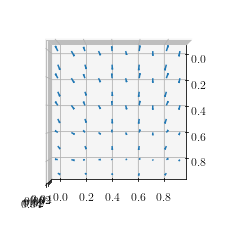

In [42]:
fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.real(loc_ar[:,0])
y = np.real(loc_ar[:,1])
z = np.zeros(len(x))

u = np.real(spin_ar[:,0])
v = np.real(spin_ar[:,1])
w = np.real(spin_ar[:,2])

ax.quiver(x,y,z,u,v,w, normalize=True, length=0.05)


ax.view_init(elev=90, azim=0)
plt.show()